# Hyperparameter Tuning
in this notebook we will apply the techinques off which we tune the hyperparameters to optimize the network, and prevent *overfitting*.

In [180]:
# imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [181]:
# read all words
words = open('names.txt').read().splitlines()
words[:7]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia']

In [182]:
len(words)

32033

In [183]:
# build vocabulary of charactars and mapping to/from integers(indexes)
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)} # map from charactors to integers
stoi['.'] = 0 # '.' will be a special character indicating word end

itos = {i:s for s, i in stoi.items()} # map from integers to characters
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [184]:
# build the datset
block_size = 3 # character context size: how many characters it takes to predict the next character

X, Y = [], []
for w in words:
    
    # print(w)
    context = [0] * block_size
    for c in w + '.':
        idx = stoi[c]
        X.append(context)
        Y.append(idx)
        # print(''.join(itos[i] for i in context), '---->', c)
        context = context[1:] + [idx]

X = torch.tensor(X)
Y = torch.tensor(Y)
        

In [185]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [186]:
# split: training set, dev/validation set, testing set
#           80%      ,       10%         ,    10%

In [187]:
def build_dataset(words):
    block_size = 3 # character context size: how many characters it takes to predict the next character

    X, Y = [], []
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for c in w + '.':
            idx = stoi[c]
            X.append(context)
            Y.append(idx)
            # print(''.join(itos[i] for i in context), '---->', c)
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [188]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [213]:
# initialize the neural network
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # embedding matrix: maps 27 charachers to 2 dimensional space
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
print("total number of parameters:", sum(p.nelement() for p in parameters))
for p in parameters: # reset the gradients
    p.requires_grad = True

total number of parameters: 10281


In [231]:
# run this code until you get a plateou, start with lr = 0.1 then decay learning rate every time you run
for i in range(10000):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.05
    for p in parameters:
        p.data += -lr * p.grad

    
# print(loss.item())

In [232]:
# loss for all training set
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
loss

tensor(2.3638, grad_fn=<NllLossBackward0>)

In [233]:
# loss for all dev set
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
loss

tensor(2.3659, grad_fn=<NllLossBackward0>)

- we see training loss, validation loss are not very different
- we assume that the model is not complex enough to memorise the training set and overfit the training data.

In [234]:
# first tune -> initialize the hidden layer with 300 neurons, 30000 iterations repeated with learning rate decay
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # embedding matrix: maps 27 charachers to 2 dimensional space
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
print("total number of parameters:", sum(p.nelement() for p in parameters))
for p in parameters: # reset the gradients
    p.requires_grad = True

total number of parameters: 10281


In [235]:
stepi = []
lossi = []

In [255]:
# start with lr=0.1 then decay it and re-run
for i in range(30000):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.item())

    
# print(loss.item())

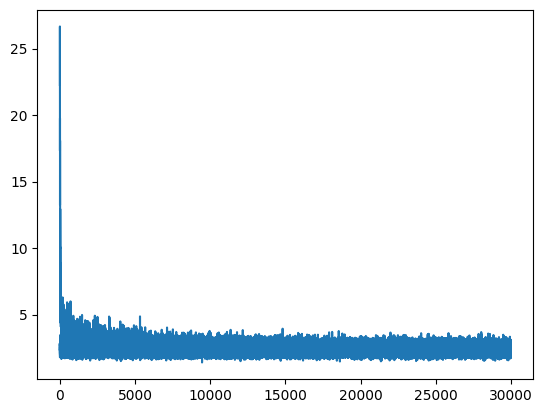

In [256]:
plt.plot(stepi, lossi);

In [257]:
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
print("training loss:", loss.item())

training loss: 2.234766960144043


In [258]:
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
print("validation loss:", loss.item())

validation loss: 2.2430243492126465


- training and validation loss are decreased, but they are not very different (a sign of *underfitting* still)

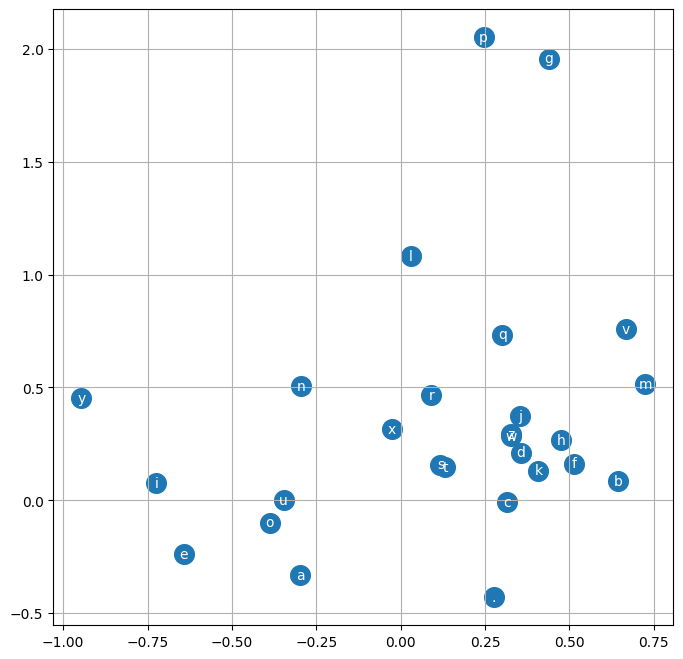

In [260]:
# visualize the character embedding space
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

- note that the vowels `a, i, e, o, u` are close to each other making a cluster, meaning they appear in similar context (similar embeddings (inputs) -> similar outputs)
- also note that some characters are far from other characters, meaning they are not similar or they are special characters (e.g., `.`).

In [261]:
# second tune -> expand the embedding vectors to a higher dimension (e.g., 10), 200000 iterations, lr= 0.1 or 0.01, hidden layer neurons = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # embedding matrix: maps 27 character to a 10 dimensional space.
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
print("total number of parameters:", sum(p.nelement() for p in parameters))
for p in parameters: # reset the gradients
    p.requires_grad = True

total number of parameters: 11897


In [262]:
stepi = []
lossi = []

In [263]:
# run this code until you get a plateau in the loss then decay the learning rate
for i in range(200000):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # first 100000 iterations with lr=0.1 then lr=0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) # this time printing log-loss

    
# print(loss.item())

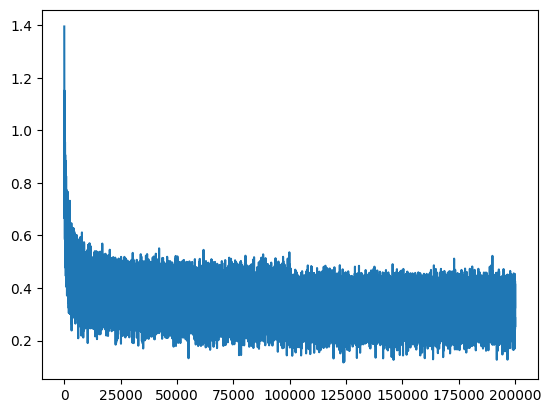

In [264]:
plt.plot(stepi, lossi);

In [265]:
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
print("training loss:", loss.item())

training loss: 2.1088967323303223


In [266]:
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
print("validation loss:", loss.item())

validation loss: 2.152947425842285


- now we are getting a difference between training and validation sets in terms of losses, we are *overfitting*.
- also the training loss and validation loss is better.

In [1028]:
# tune 3: batch_size = 12, n-neurons = 100, n-previous characters(block-size) = 4
def build_dataset(words):
    block_size = 4 # character context size: how many characters it takes to predict the next character

    X, Y = [], []
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for c in w + '.':
            idx = stoi[c]
            X.append(context)
            Y.append(idx)
            # print(''.join(itos[i] for i in context), '---->', c)
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 4]) torch.Size([182441])
torch.Size([22902, 4]) torch.Size([22902])
torch.Size([22803, 4]) torch.Size([22803])


In [1053]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # embedding matrix: maps 27 character to a 10 dimensional space.
W1 = torch.randn((40, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
print("total number of parameters:", sum(p.nelement() for p in parameters))
for p in parameters: # reset the gradients
    p.requires_grad = True

total number of parameters: 7097


In [1054]:
# run this code until you get a plateau in the loss then decay the learning rate
for i in range(200000):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (128, ))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view((-1, 40)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.5 if i < 100000 else 0.1 # first 100000 iterations with lr=0.1 then lr=0.01
    # lr = 0.1
    # lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0:
        emb = C[Xtr]
        h = torch.tanh(emb.view((-1, 40)) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
        print("training loss:", loss.item())
    # stepi.append(i)
    # lrei.append(lre[i])
    # lossi.append(loss.item()) # this time printing log-loss

    
# print(loss.item())

training loss: 16.03428840637207
training loss: 2.7302029132843018
training loss: 2.3773858547210693
training loss: 2.2812795639038086
training loss: 2.2789113521575928
training loss: 2.268502712249756
training loss: 2.3659827709198
training loss: 2.2304108142852783
training loss: 2.244175910949707
training loss: 2.1829757690429688
training loss: 2.165090799331665
training loss: 2.080970287322998
training loss: 2.072991132736206
training loss: 2.080254316329956
training loss: 2.077906608581543
training loss: 2.076594352722168
training loss: 2.0745108127593994
training loss: 2.0741214752197266
training loss: 2.073082447052002
training loss: 2.067107915878296


In [1056]:
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 40)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
print("training loss:", loss.item())

training loss: 2.0692827701568604


In [1057]:
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 40)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
print("validation loss:", loss.item())

validation loss: 2.1326630115509033


- this is the best hyperparameters so far, we will keep them

In [1075]:
# finally, the test set
emb = C[Xte]
h = torch.tanh(emb.view((-1, 40)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
print("testing loss:", loss.item())

testing loss: 2.1341936588287354


- the model have never seen the testing set before, the loss didn't increase indicating we are generalizing!

## Generating names from the model

In [1073]:
g = torch.Generator().manual_seed(2147483647)
block_size = 4

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view((-1, 40)) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

junide.
jakarie.
presty.
adria.
jiin.
tolima.
juhzen.
lania.
yanilee.
asshedaine.
imelys.
jainay.
arter.
nouumera.
oltume.
ponts.
jahruan.
reora.
yarion.
kaevandyn.


- we see that we are producing name-like words, more similar to names than the previous notebook 